In [34]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import os
import random
import time
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import copy
from collections import OrderedDict
import time
from torchvision import datasets
import numpy as np
from torchvision.utils import make_grid, save_image
from statistics import mean

In [35]:
def downsample_block(n_channels):
    return nn.Sequential(
        nn.Conv2d(n_channels, 2*n_channels, 3, stride=2, padding=1),
        nn.InstanceNorm2d(n_channels),
        nn.ReLU())
    

def upsample_block(n_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(2*n_channels, n_channels, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(n_channels),
        nn.ReLU()
    )

def residual_block(n_channels):
    return nn.Sequential(
        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(n_channels, n_channels, 3, stride=1, padding=0),
        nn.InstanceNorm2d(n_channels),
        nn.ReLU(),
        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(n_channels, n_channels, 3, stride=1, padding=0),
        nn.InstanceNorm2d(n_channels),
    )
    

def patch_layer(n_channels):
    
    return nn.Sequential(
          nn.Conv2d(n_channels,2*n_channels,4,padding=1,stride=2),
          nn.InstanceNorm2d(2*n_channels),
          nn.LeakyReLU(negative_slope=0.2)
      )

In [36]:
class Generator(nn.Module):
    def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
          nn.ReflectionPad2d(padding=3),
          nn.Conv2d(3, 64, 7, stride=1, padding=0),
          nn.InstanceNorm2d(64),
          nn.ReLU(),
          downsample_block(64),
          downsample_block(128),
          residual_block(256),
          residual_block(256),
          residual_block(256),
          residual_block(256),
          residual_block(256),
          residual_block(256),
          residual_block(256),
          residual_block(256),
          residual_block(256),
          upsample_block(128),
          upsample_block(64),
          nn.ReflectionPad2d(padding=3),
          nn.Conv2d(64, 3, 7, stride=1, padding=0),
          nn.Sigmoid(),
      )

    def forward(self, X):
      return self.model(X)

In [37]:
class Discriminator(nn.Module):
   
    def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
          nn.Conv2d(3,64,4,padding=1,stride=2),
          nn.LeakyReLU(negative_slope=0.2),
          patch_layer(64),
          patch_layer(128),
          patch_layer(256),
          nn.Conv2d(512,1,4,padding=1),
      )

    def forward(self, X):
      x = self.model(X)
      x = x.mean([-2,-1])
      return x

In [38]:
class GAN():

  def __init__(self, loss_lambda = 0.8, buffer_dim = 50):
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.G_xy = Generator().to(self.device)
      self.G_yx = Generator().to(self.device)
      self.D_xy = Discriminator().to(self.device)
      self.D_yx = Discriminator().to(self.device)
      self.losses = []
      self.buffer_dim = buffer_dim
      self.fake_x_buffer = []
      self.fake_y_buffer = []
      self.G_loss_decaying_average = 0.5
      self.loss_average_lambda = loss_lambda
      
  def train_generator(self,X,Y,optimisers):
      optimisers['G_xy_optimiser'].zero_grad()
      optimisers['G_yx_optimiser'].zero_grad()
      
      fake_y = self.G_xy(X)
      fake_x = self.G_yx(Y)
      self.update_buffers(fake_x[torch.randint(bs,(1,))],fake_y[torch.randint(bs,(1,))])
      xy_loss = torch.mean((self.D_xy(fake_y) - 1) ** 2)
      yx_loss = torch.mean((self.D_yx(fake_x) - 1) ** 2)
      recon_x = self.G_yx(fake_y)
      recon_y = self.G_xy(fake_x)
      cyc_loss = cyc_lambda*(torch.mean(torch.abs(recon_y - Y)) + torch.mean(torch.abs(recon_x - X)))
      id_loss = id_lambda*(torch.mean(torch.abs(self.G_xy(Y) - Y)) + torch.mean(torch.abs(self.G_yx(X) - X)))

      loss = xy_loss + yx_loss + cyc_loss + id_loss
      loss.backward()

      optimisers['G_xy_optimiser'].step()
      optimisers['G_yx_optimiser'].step()

      return xy_loss, yx_loss, cyc_loss, id_loss

  def train_discriminator(self,X,Y,optimisers):
      optimisers['D_xy_optimiser'].zero_grad()
      optimisers['D_yx_optimiser'].zero_grad()

      fake_x = self.fake_x_buffer[torch.randint(len(self.fake_x_buffer),(bs,))]
      fake_y = self.fake_y_buffer[torch.randint(len(self.fake_y_buffer),(bs,))]

      d_xy_loss = torch.mean(self.D_xy(fake_y) ** 2) + torch.mean((self.D_xy(Y) - 1) ** 2)
      d_yx_loss = torch.mean(self.D_yx(fake_x) ** 2) + torch.mean((self.D_yx(X) - 1) ** 2)

      loss = d_xy_loss + d_yx_loss
      loss.backward()

      optimisers['D_xy_optimiser'].step()
      optimisers['D_yx_optimiser'].step()

      return d_xy_loss, d_yx_loss

  def plot_loss(self, losses):
      x = []
      xy_loss = []
      yx_loss = []
      cyc_loss = []
      id_loss = []
      d_xy_loss = []
      d_yx_loss = []
      for i in range(len(losses)):
        x.append(i)
        xy_loss.append(losses[i][0])
        yx_loss.append(losses[i][1])
        cyc_loss.append(losses[i][2])
        id_loss.append(losses[i][3])
        d_xy_loss.append(losses[i][4])
        d_yx_loss.append(losses[i][5])
      plt.plot(x,xy_loss, label='XY_Loss')
      plt.plot(x,yx_loss, label='YX_Loss')
      plt.plot(x,cyc_loss, label='Cyc_Loss')
      plt.plot(x,id_loss, label='ID_Loss')
      plt.plot(x,d_xy_loss, label='Discriminator_XY_Loss')
      plt.plot(x,d_yx_loss, label='Discriminator_YX_Loss')
      plt.title('Loss Progression')
      plt.xlabel('Steps')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
  
  def load_weights(self):
      self.G_xy.load_state_dict(torch.load(drive_path + 'G_xy.pt', map_location=torch.device(self.device)))
      self.G_yx.load_state_dict(torch.load(drive_path + 'G_yx.pt', map_location=torch.device(self.device)))
      self.D_xy.load_state_dict(torch.load(drive_path + 'D_xy.pt', map_location=torch.device(self.device)))
      self.D_yx.load_state_dict(torch.load(drive_path + 'D_yx.pt', map_location=torch.device(self.device)))
      print("Weights Loaded")

  def save_weights(self):
      torch.save(self.G_xy.state_dict(), drive_path + 'G_xy.pt')
      torch.save(self.G_yx.state_dict(), drive_path + 'G_yx.pt')
      torch.save(self.D_xy.state_dict(), drive_path + 'D_xy.pt')
      torch.save(self.D_yx.state_dict(), drive_path + 'D_yx.pt')
      print("Weights Saved")
  
  def initiate_buffers(self,X,Y):
      self.fake_x_buffer = self.G_yx(Y.to(self.device)).detach()
      self.fake_y_buffer = self.G_xy(X.to(self.device)).detach()
  
  def update_buffers(self,X,Y):
      self.fake_x_buffer = torch.cat((self.fake_x_buffer,X.detach()),dim=0)
      self.fake_y_buffer = torch.cat((self.fake_y_buffer,Y.detach()),dim=0)
      if len(self.fake_x_buffer) > self.buffer_dim:
        self.fake_x_buffer = self.fake_x_buffer[1:]
      if len(self.fake_y_buffer) > self.buffer_dim:
        self.fake_y_buffer = self.fake_y_buffer[1:]

  def train(self, optimisers, epochs):
      
      if len(self.fake_x_buffer) == 0:
        self.initiate_buffers(next(iter(input_dataloader)),next(iter(target_dataloader)))
      for epoch in range(epochs):
        start = time.time()
        xy_loss, yx_loss, cyc_loss, id_loss, d_xy_loss, d_yx_loss = [],[],[],[],[],[]
        for batch, (X,Y) in enumerate(zip(input_dataloader,target_dataloader)):
          X,Y = X.to(self.device), Y.to(self.device)
          xy_loss_b, yx_loss_b, cyc_loss_b, id_loss_b = self.train_generator(X,Y,optimisers)
          self.G_loss_decaying_average = (1 - self.loss_average_lambda) * (xy_loss_b + yx_loss_b) + self.loss_average_lambda * self.G_loss_decaying_average
          if self.G_loss_decaying_average < 0.5:
            d_xy_loss_b, d_yx_loss_b = self.train_discriminator(X,Y,optimisers)
            d_xy_loss.append(d_xy_loss_b.item())
            d_yx_loss.append(d_yx_loss_b.item())
          xy_loss.append(xy_loss_b.item())
          yx_loss.append(yx_loss_b.item())
          cyc_loss.append(cyc_loss_b.item())
          id_loss.append(id_loss_b.item())
        xy_loss = mean(xy_loss)
        yx_loss = mean(yx_loss)
        cyc_loss = mean(cyc_loss)/cyc_lambda
        id_loss = mean(id_loss)/id_lambda
        if len(d_xy_loss) == 0:
          d_xy_loss = 0
        else:
          d_xy_loss = mean(d_xy_loss)
        if len(d_yx_loss) == 0:
          d_yx_loss = 0
        else:
          d_yx_loss = mean(d_yx_loss)
        epoch_losses = [xy_loss,yx_loss,cyc_loss,id_loss, d_xy_loss, d_yx_loss]
        self.losses.append(epoch_losses)
        finish = time.time()
        print('[Epoch {0}/{1} {2:6.3f}s] G Loss: {3:6.3f}, D Loss: {4:6.3f}, Cyc Loss: {5:6.3f}, ID Loss: {6:6.3f}'.format(
            epoch+1,
            epochs,
            finish - start,
            epoch_losses[0] + epoch_losses[1],
            epoch_losses[4] + epoch_losses[5],
            epoch_losses[2],
            epoch_losses[3]
        ))
      self.plot_loss(self.losses)

In [43]:
epochs = 15                          
image_size = 256                     
lr = 0.0001                           
beta1 = 0.5                           
beta2 = 0.999                         
bs = 2                                
cyc_lambda = 10                      
id_lambda = 1                        
use_saved_weights = False   

In [44]:
class Dataset(Dataset):

  def __init__(self, directory_path):
    path_list = os.listdir(directory_path)
    abspath = os.path.abspath(directory_path) 
    self.img_dir = directory_path
    self.img_list = [os.path.join(abspath, path) for path in path_list]
    self.transform = transforms.Compose([
          transforms.Resize(image_size),
          transforms.ToTensor(),
    ])

  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, idx):
    path = self.img_list[idx]
    img = Image.open(path)
    return self.transform(img)

In [45]:
input_images = Dataset('gan-getting-started/' + 'photo_jpg')
target_images = Dataset('gan-getting-started/' + 'monet_jpg')
input_dataloader = DataLoader(input_images, batch_size=bs, shuffle=True)
target_dataloader = DataLoader(target_images, batch_size=bs, shuffle=True)
model = GAN()
optimisers = {
    'G_xy_optimiser': torch.optim.Adam(model.G_xy.parameters(),lr=lr, betas=(beta1,beta2)),
    'G_yx_optimiser': torch.optim.Adam(model.G_yx.parameters(),lr=lr, betas=(beta1,beta2)),
    'D_xy_optimiser': torch.optim.Adam(model.D_xy.parameters(),lr=lr, betas=(beta1,beta2)),
    'D_yx_optimiser': torch.optim.Adam(model.D_yx.parameters(),lr=lr, betas=(beta1,beta2))
}

[Epoch 1/15 81.700s] G Loss:  0.725, D Loss:  0.523, Cyc Loss:  0.349, ID Loss:  0.351
[Epoch 2/15 84.388s] G Loss:  0.207, D Loss:  0.436, Cyc Loss:  0.313, ID Loss:  0.306
[Epoch 3/15 84.100s] G Loss:  0.205, D Loss:  0.414, Cyc Loss:  0.304, ID Loss:  0.297
[Epoch 4/15 78.236s] G Loss:  0.198, D Loss:  0.373, Cyc Loss:  0.312, ID Loss:  0.307
[Epoch 5/15 80.373s] G Loss:  0.215, D Loss:  0.443, Cyc Loss:  0.297, ID Loss:  0.307
[Epoch 6/15 84.850s] G Loss:  0.193, D Loss:  0.425, Cyc Loss:  0.285, ID Loss:  0.300
[Epoch 7/15 84.841s] G Loss:  0.208, D Loss:  0.413, Cyc Loss:  0.280, ID Loss:  0.295
[Epoch 8/15 84.806s] G Loss:  0.208, D Loss:  0.376, Cyc Loss:  0.283, ID Loss:  0.299
[Epoch 9/15 84.760s] G Loss:  0.181, D Loss:  0.380, Cyc Loss:  0.276, ID Loss:  0.291
[Epoch 10/15 84.748s] G Loss:  0.163, D Loss:  0.324, Cyc Loss:  0.268, ID Loss:  0.285
[Epoch 11/15 84.732s] G Loss:  0.173, D Loss:  0.337, Cyc Loss:  0.257, ID Loss:  0.276
[Epoch 12/15 84.769s] G Loss:  0.177, D L

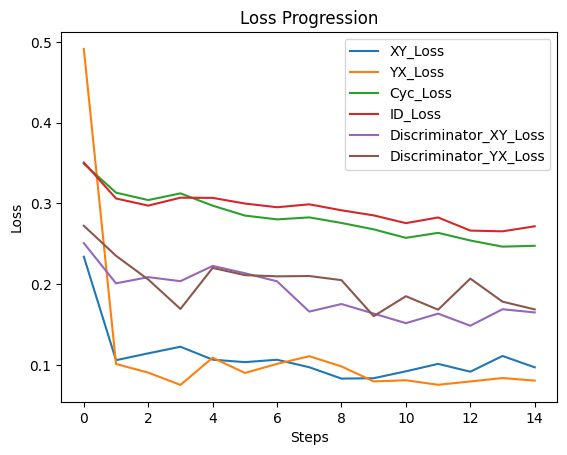

In [46]:
model.train(optimisers, epochs=epochs)

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
def save_pictures(input_images):
    if not os.path.isdir('images'):
        os.makedirs('images')
    os.chdir('images')
    for i in tqdm(range(len(input_images))):
        img = input_images[i]
        fake_img = model.G_xy(img.to(device)).cpu().squeeze().detach()
        img_name = f'image-{i+1}.jpg'
        save_image(fake_img,img_name)

In [49]:
os.chdir('E:\kaggle_I’m Something of a Painter Myself')
os.getcwd()

'E:\\kaggle_I’m Something of a Painter Myself'

In [50]:

save_pictures(input_images)
os.chdir('E:\kaggle_I’m Something of a Painter Myself')
shutil.make_archive('kaggle/working/'+'images','zip', base_dir='images')

100%|██████████| 7038/7038 [02:22<00:00, 49.42it/s]


'kaggle/working/images.zip'

In [51]:
torch.save(model, 'model.pth')

In [52]:
m = torch.load('model.pth')